In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import SGD
from scipy.ndimage.interpolation import shift
import pandas as pd 

In [2]:
with open("history.txt",'r') as historyFile:
        lines = historyFile.readlines()
        gamehistory=[]
        for x in lines:
            x=x[1:]
            x=x[:-2]
            gamehistory.append(x)
        print(gamehistory)

        

['1, 1, 5, 4, 3, 0, 8, 7', '-1, 4, 8, 1, 6, 0, 2, 3, 5', '-1, 4, 3, 5, 0, 7, 1, 6, 2', '-1, 7, 0, 5, 8, 6, 4', '-1, 6, 5, 0, 8, 1, 4, 7, 2', '1, 5, 4, 7, 3, 2, 0, 6, 1, 8', '1, 4, 0, 8, 3, 7, 5, 6', '1, 4, 3, 8, 5, 1, 7, 2, 0, 6', '1, 4, 6, 5, 2, 3', '-1, 5, 4, 0, 1, 2, 7']


In [3]:
inputGame=[]
output=[]

for games in gamehistory:
    if(games[0]=='-'):
        inputGame.append(-1)
        output.append(games[1:])
    
print(inputGame)
print(output)

[-1, -1, -1, -1, -1]
['1, 4, 8, 1, 6, 0, 2, 3, 5', '1, 4, 3, 5, 0, 7, 1, 6, 2', '1, 7, 0, 5, 8, 6, 4', '1, 6, 5, 0, 8, 1, 4, 7, 2', '1, 5, 4, 0, 1, 2, 7']


In [4]:
def createData(dataset):
        inputGame = []
        output = []
        for data in dataset:
            inputGame.append(data[1])
            output.append(data[0])

        X = np.array(inputGame).reshape((-1, len(inputGame)))
        y = to_categorical(output, num_classes=3)
        # Train and test data split
        boundary = int(0.8 * len(X))
        x_train = X[:boundary]
        x_test = X[boundary:]
        y_train = y[:boundary]
        y_test = y[boundary:]


In [5]:
model = keras.Sequential()
model.add(layers.Dense(18, input_dim=9,kernel_initializer='normal', activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(9, kernel_initializer='normal',activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1,kernel_initializer='normal'))

learning_rate = 0.001
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum,nesterov=False)
model.compile(loss='mean_squared_error', optimizer=sgd)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                180       
_________________________________________________________________
dropout (Dropout)            (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 171       
_________________________________________________________________
dropout_1 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 10        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [6]:
def legal_moves_generator(current_board_state):
    """Function that returns the set of all possible legal moves and resulting board states, 
    for a given input board state and player

    Args:
    current_board_state: The current board state


    Returns:
    legal_moves_dict: A dictionary of a list of possible next coordinate-resulting board state pairs
    The resulting board state is flattened to 1 d array

    """
    current_board_state = np.array(current_board_state).reshape(3,3)
    legal_moves_dict={}
    for i in range(current_board_state.shape[0]):
        for j in range(current_board_state.shape[1]):
            if current_board_state[i,j]==0:
                board_state_copy=current_board_state.copy()
                legal_moves_dict[(i,j)]=board_state_copy.flatten()
    return legal_moves_dict

In [7]:
def move_selector(model,current_board_state):
    current_board_state = np.array(current_board_state).reshape(3,3)
    tracker={}
    legal_moves_dict=legal_moves_generator(current_board_state)
    for legal_move_coord in legal_moves_dict:
        score=model.predict(legal_moves_dict[legal_move_coord].reshape(1,9))
        tracker[legal_move_coord]=score

    selected_move=max(tracker, key=tracker.get)

    new_board_state=legal_moves_dict[selected_move]
    score=tracker[selected_move]

    return selected_move,new_board_state,score


In [8]:
import os
import random
import copy

#X's are 1, O's are -1, empty is 0
#check if 3 in a row has been made
def checkWin(board):
    win = 0
    winningLines = [[0, 1, 2],[3, 4, 5],[6, 7, 8],[0, 3, 6],[1, 4, 7],[2, 5, 8],[0, 4, 8],[2, 4, 6]]
    for x in winningLines:
        if( board[x[0]]==1 and  board[x[1]]==1 and  board[x[2]]==1):
            win = 1
        elif(board[x[0]]==-1 and  board[x[1]]==-1 and  board[x[2]]==-1):
            win = -1
    return win
#find which parts of the array are available
def findLegalMoves(board):
    legalMoves=[]
    for i in range(len(board)):
        if board[i] == 0:
            legalMoves.append(i)
    return legalMoves

#why didn't I use a dictionary
def createBoard(board):
    physicalBoard=[]
    for x in board:
        if x == -1:
            physicalBoard.append('O')
        elif x == 1:
            physicalBoard.append('X')
        elif x == 0:
            physicalBoard.append(" ")

    return physicalBoard
#display board
def printBoard(board):
    physicalBoard = createBoard(board)

    print(physicalBoard[0]+"|"+physicalBoard[1]+"|"+physicalBoard[2])
    print("-+-+-")
    print(physicalBoard[3]+"|"+physicalBoard[4]+"|"+physicalBoard[5])
    print("-+-+-")
    print(physicalBoard[6]+"|"+physicalBoard[7]+"|"+physicalBoard[8]+"\n")
def printHelpBoard():
    print("\nChoose a place to put your piece using the following guide:")
    print("0"+"|"+"1"+"|"+"2")
    print("-+-+-")
    print("3"+"|"+"4"+"|"+"5")
    print("-+-+-")
    print("6"+"|"+"7"+"|"+"8\n")




In [9]:
def opponent_move_selector(current_board_state):
    current_board_state = np.array(current_board_state).reshape(3,3)

    legal_moves_dict=legal_moves_generator(current_board_state)
    selected_move = random.choice(list(legal_moves_dict.keys()))
    selected_move = selected_move[0]*3+selected_move[1]

    
    
    return selected_move

In [10]:
def train(model):
    """Function trains the Evaluator (model) by playing a game against an opponent 
    playing random moves, and updates the weights of the model after the game
    
    Note that the model weights are updated using SGD with a batch size of 1

    Args:
    model: The Evaluator function being trained

    Returns:
    model: The model updated using SGD
    y: The corrected scores

    """ 
    # start the game
    board=[0,0,0,0,0,0,0,0,0]
    scores_list=[]
    corrected_scores_list=[]
    new_board_states_list=[]
    piecesPlayed = 0
    #while game going
    while(piecesPlayed<9):
         #if x's turn
            if(piecesPlayed%2==0):
                selectedMove= opponent_move_selector(board)
                board[selectedMove]=1
            #else if programs turn   
            else:
                selected_move,new_board_state,score=move_selector(model,board)
                scores_list.append(score[0][0])
                new_board_states_list.append(new_board_state)
                # Make the next move
                selected_move=selected_move[0]*3+selected_move[1]
                board[selected_move]=-1                       
            piecesPlayed = piecesPlayed + 1
            win = checkWin(board)
            if (win == 1):
                gameOver = True

            elif(win == -1):

                gameOver = True

            elif(piecesPlayed == 9):

                gameOver = True


    
    # Correct the scores, assigning 1/0/-1 to the winning/drawn/losing final board state, 
    # and assigning the other previous board states the score of their next board state
    new_board_states_list=tuple(new_board_states_list)
    new_board_states_list=np.vstack(new_board_states_list)
    if (win==-1): 
        corrected_scores_list=shift(scores_list,-1,cval=1.0)
        result="Won"
    elif (win==1):
        corrected_scores_list=shift(scores_list,-1,cval=-1.0)
        result="Lost"
    elif (win==0):
        corrected_scores_list=shift(scores_list,-1,cval=0.0)
        result="Drawn"
        
    x=new_board_states_list
    y=corrected_scores_list
    
    def unison_shuffled_copies(a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]
    
    # shuffle x and y in unison
    x,y=unison_shuffled_copies(x,y)
    x=x.reshape(-1,9) 
    
    # update the weights of the model, one record at a time
    model.fit(x,y,epochs=1,batch_size=1,verbose=0)
    return model,y,result

In [11]:
game_counter=1
data_for_graph=pd.DataFrame()
while(game_counter<=1000):
    model,y,result=train(model)
    data_for_graph=data_for_graph.append({"game_counter":game_counter,"result":result},ignore_index=True)
    game_counter+=1
    print("Game number:"+str(game_counter)+"done.")
print("Done processing games.")

Game number:972done.
Game number:973done.
Game number:974done.
Game number:975done.
Game number:976done.
Game number:977done.
Game number:978done.
Game number:979done.
Game number:980done.
Game number:981done.
Game number:982done.
Game number:983done.
Game number:984done.
Game number:985done.
Game number:986done.
Game number:987done.
Game number:988done.
Game number:989done.
Game number:990done.
Game number:991done.
Game number:992done.
Game number:993done.
Game number:994done.
Game number:995done.
Game number:996done.
Game number:997done.
Game number:998done.
Game number:999done.
Game number:1000done.
Game number:1001done.
Done processing games.


Text(0.5, 1.0, 'Distribution of Results Vs Count of Games Played')

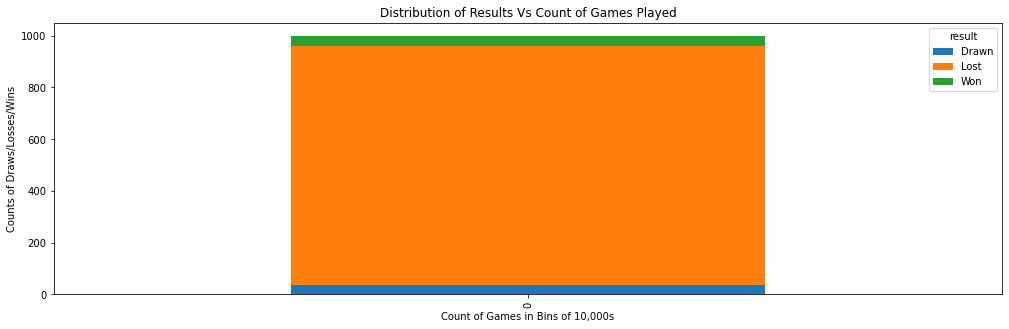

In [14]:
bins = np.arange(1, game_counter/10000) * 10000
data_for_graph['game_counter_bins'] = np.digitize(data_for_graph["game_counter"], bins, right=True)
counts = data_for_graph.groupby(['game_counter_bins', 'result']).game_counter.count().unstack()
ax=counts.plot(kind='bar', stacked=True,figsize=(17,5))
ax.set_xlabel("Count of Games in Bins of 10,000s")
ax.set_ylabel("Counts of Draws/Losses/Wins")
ax.set_title('Distribution of Results Vs Count of Games Played')

In [16]:
model.save('tictactoe1000_model.h5')